In [584]:
import dgl
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime
import calendar
from pandas.api.types import CategoricalDtype
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
# pandas datframe setting
pd.set_option('display.max_columns', None)

## Dataset Creation

In [3]:
customer_data = pd.read_csv('archive/olist_customers_dataset.csv')
geolocation_data = pd.read_csv('archive/olist_geolocation_dataset.csv')
order_items_dataset = pd.read_csv('archive/olist_order_items_dataset.csv')
order_payments_dataset = pd.read_csv('archive/olist_order_payments_dataset.csv')
order_reviews_dataset = pd.read_csv('archive/olist_order_reviews_dataset.csv')
order_dataset = pd.read_csv('archive/olist_orders_dataset.csv')
order_products_dataset = pd.read_csv('archive/olist_products_dataset.csv')
order_sellers_dataset = pd.read_csv('archive/olist_sellers_dataset.csv')
product_translation_dataset = pd.read_csv('archive/product_category_name_translation.csv')

In [4]:
order_reviews_dataset = order_reviews_dataset[['order_id','review_score', 'review_comment_message']]
order_review_data = order_reviews_dataset.merge(order_dataset,on='order_id')
order_products_dataset_english = pd.merge(order_products_dataset,product_translation_dataset,on='product_category_name', how='left')
order_products_dataset_english = order_products_dataset_english.drop(labels='product_category_name',axis=1)
order_product_item_dataset = pd.merge(order_items_dataset,order_products_dataset_english,on='product_id')
ordered_product_reviews = pd.merge(order_product_item_dataset,order_review_data,on='order_id')
ordered_product_reviews_payments = pd.merge(ordered_product_reviews,order_payments_dataset,on='order_id')
df_final = pd.merge(ordered_product_reviews_payments,customer_data,on='customer_id')

In [5]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117329 entries, 0 to 117328
Data columns (total 32 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       117329 non-null  object 
 1   order_item_id                  117329 non-null  int64  
 2   product_id                     117329 non-null  object 
 3   seller_id                      117329 non-null  object 
 4   shipping_limit_date            117329 non-null  object 
 5   price                          117329 non-null  float64
 6   freight_value                  117329 non-null  float64
 7   product_name_lenght            115634 non-null  float64
 8   product_description_lenght     115634 non-null  float64
 9   product_photos_qty             115634 non-null  float64
 10  product_weight_g               117309 non-null  float64
 11  product_length_cm              117309 non-null  float64
 12  product_height_cm             

In [6]:
df_final.isnull().sum()

order_id                             0
order_item_id                        0
product_id                           0
seller_id                            0
shipping_limit_date                  0
price                                0
freight_value                        0
product_name_lenght               1695
product_description_lenght        1695
product_photos_qty                1695
product_weight_g                    20
product_length_cm                   20
product_height_cm                   20
product_width_cm                    20
product_category_name_english     1720
review_score                         0
review_comment_message           67650
customer_id                          0
order_status                         0
order_purchase_timestamp             0
order_approved_at                   15
order_delivered_carrier_date      1235
order_delivered_customer_date     2471
order_estimated_delivery_date        0
payment_sequential                   0
payment_type             

The maximum missing values is seen in the order delivery date feature of the data set with around 2% of the total data. For the numerical features with null values we will use median to handle missing value of these columns. For the date column order delivery date and order approve date we will fill the missing value from the corresponfiing estimated delivery date column and order purchase time column. The customer generally does not pay attention to the order_delivered_carrier_date of their order. so, we will drop this column. Also, the categorical product category feature have null values less than 1% of total data so, we will drop those rows having null values.


In [7]:
# Handling missing values
df_final['product_name_lenght'].fillna(df_final['product_name_lenght'].median(),inplace=True)
df_final['product_description_lenght'].fillna(df_final['product_description_lenght'].median(),inplace=True)
df_final['product_photos_qty'].fillna(df_final['product_photos_qty'].median(),inplace=True)
df_final['product_weight_g'].fillna(df_final['product_weight_g'].median(),inplace=True)
df_final['product_length_cm'].fillna(df_final['product_length_cm'].median(),inplace=True)
df_final['product_height_cm'].fillna(df_final['product_height_cm'].median(),inplace=True)
df_final['product_width_cm'].fillna(df_final['product_width_cm'].median(),inplace=True)

In [8]:
#Handling missing values
ids = (df_final[df_final['order_delivered_customer_date'].isnull() == True].index.values)
vals = df_final.iloc[ids]['order_estimated_delivery_date'].values
df_final.loc[ids,'order_delivered_customer_date'] = vals

ids = (df_final[df_final['order_approved_at'].isnull() == True].index.values)
df_final.loc[ids,'order_approved_at'] = df_final.iloc[ids]['order_purchase_timestamp'].values

df_final.drop(labels='order_delivered_carrier_date',axis=1,inplace=True)

In [9]:
df_final['review_comment_message'].fillna('no_review',inplace=True)

In [10]:
df_final = df_final.dropna()

In [11]:
n1=df_final.shape[0]

In [12]:
print('After dropping we still have {:0.1%} of the data'.format(df_final.shape[0]/n1))

After dropping we still have 100.0% of the data


In [13]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115609 entries, 0 to 117328
Data columns (total 31 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       115609 non-null  object 
 1   order_item_id                  115609 non-null  int64  
 2   product_id                     115609 non-null  object 
 3   seller_id                      115609 non-null  object 
 4   shipping_limit_date            115609 non-null  object 
 5   price                          115609 non-null  float64
 6   freight_value                  115609 non-null  float64
 7   product_name_lenght            115609 non-null  float64
 8   product_description_lenght     115609 non-null  float64
 9   product_photos_qty             115609 non-null  float64
 10  product_weight_g               115609 non-null  float64
 11  product_length_cm              115609 non-null  float64
 12  product_height_cm             

## Dataset Analysis

In [18]:
# checking the review score 
df_final.review_score.value_counts()

5    65374
4    21951
1    14546
3     9718
2     4020
Name: review_score, dtype: int64

In [14]:
# df_final['Year'] = df_final['order_purchase_timestamp'].dt.year
# df_final.groupby('Year').size().plot(kind = 'bar',figsize=(12,5));
# plt.title('Years',fontsize=20);
# plt.xlabel('Year',fontsize=15);
# plt.xticks(rotation=0);

In [15]:
# df_final['Month'] =  pd.Series(pd.Categorical(df_final['order_purchase_timestamp'].dt.month_name(), categories=list(calendar.month_name)))
# df_final.groupby('Month').size().plot(kind = 'bar',figsize=(15,5))
# plt.title('Months counts in all years',fontsize=20);
# plt.xlabel('Month',fontsize=15);
# plt.xticks(rotation=0);

In [17]:
# df_final['Month'] = df_final['order_purchase_timestamp'].dt.month

# print('This available data are collected from date {} to date {}'.format(
#     df_final.order_purchase_timestamp.min(), df_final.order_purchase_timestamp.max()))
# print()
# print ('For year 2016 data are for Months {}'.format(sorted(df_final.query('Year==2016').Month.unique())))
# print ('For year 2017 data are for Months {}'.format(sorted(df_final.query('Year==2017').Month.unique())))
# print ('For year 2018 data are for Months {}'.format(sorted(df_final.query('Year==2018').Month.unique())))

Total orders per year just compares only one month of 2016 with 12 Months of 2017 and 8 Months of 2018 that result in misleading information about trending up of orders.

It was expected November( Black Friday) or December(X-mas) to have the highest value. SO, let's have a deeper lock for the data.



In [18]:
# df_final['Day'] = df_final['order_purchase_timestamp'].dt.day_name()

# plt.figure(figsize=(10,7))
# basecolor=sns.color_palette()[0]
# sns.countplot(data=df_final,x='Day',order=list(calendar.day_name),color=basecolor);

# plt.title('All Order purchased in the Day in all years', fontsize=20);
# plt.xlabel('Day',fontsize=15);

In [19]:
# df_final['Hour'] = df_final['order_purchase_timestamp'].dt.hour

# plt.figure(figsize=(10,7))
# basecolor=sns.color_palette()[0]
# sns.countplot(data=df_final ,x='Hour',order=list(range(0, 24)),color=basecolor);

# plt.title('All Order purchased in the Hour', fontsize=20);
# plt.xlabel('Hour',fontsize=15);

There is no name for the items in the dataset, each item has item_id. Therefore we relate each item by category which belongs to. Below the top 10 popular categories are obtained.

In [20]:
# top_10_category = df_final["product_category_name_english"].value_counts().head(10)

# print('Top 10 frequently repeated categories')
# print('--------------------------------------')
# print(top_10_category.reset_index().rename(columns={'index':'product_category',
#                                               'product_category_name_english':'counts'}))

In [21]:
# average_price = df_final.groupby("product_category_name_english")["price"].agg(np.mean).sort_values().tail(10)

# print('Top 10 categories with highest average price.')
# print('-----------------------------------------------')
# print(average_price.sort_values(ascending=False))


In [ ]:
# https://www.kaggle.com/code/yichengs/brazilian-e-commerce-rating-prediction

In [ ]:
# work on correlation

In [ ]:
# Covariance measures the directional relationship between the returns on two assets. A positive covariance means that asset returns move together while a negative covariance means they move inversely.

In [ ]:
df.columns

In [ ]:
df = df[['order_id', 'customer_id', 'order_item_id', 'product_id', 'order_status', 'order_purchase_timestamp', 'payment_sequential','payment_type', 'payment_installments', 'payment_value', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'price', 'freight_value', 'product_category_name','product_name_lenght', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'product_category_name_english', 'Year', 'Month', 'Day', 'Hour' ]] 

In [ ]:
pd.set_option('display.max_columns', None)

## 3.4 Feature Engineering

    Sellers Count:- Number of sellers for each product as a feature.
    Products count:- Number of products ordered in each order as a feature.
    Estimated Delivery Time(in number of days):- Gets the days between order approval and estimated delivery date. A customer might be unsatisfied if he is told that the estimated time is big.
    Actual Delivery Time:- Gets the days between order approval and delivered customer date. A customer might be more satisfied if he gets the product faster.
    Difference in delivery days:- The difference between the actual and estimated date. If negative was delivered early, if positive was delivered late. A customer might be more satisfied if the order arrives sooner than expected, or unhappy if he receives after the deadline
    Is Late:- Binary variable indicating if the order was delivered after the estimated date.
    Average Product Value:- Cheaper products might have lower quality, leaving customers unhappy.
    Total Order Value:- If a customer expends more, he might expect a better order fulfilment.
    Order Freight Ratio:- If a customer pays more for freight, he might expect a better service.
    Purchase Day of Week:- Day of week on which purchase was made.
    is_reviewed:- If the review comment is given or not.

In [22]:
# Finding number of sellers for each product as a feature
product_id = order_product_item_dataset.groupby('product_id').count()['seller_id'].index
seller_count = order_product_item_dataset.groupby('product_id').count()['seller_id'].values
product_seller_count = pd.DataFrame({'product_id':product_id,'sellers_count':seller_count})
product_seller_count.head(2)

,product_id,sellers_count
0,00066f42aeeb9f3007548bb9d3f33c38,1
1,00088930e925c41fd95ebfe695fd2655,1


In [23]:
# Finding number of products ordered in each order as a feature
order_id = order_product_item_dataset.groupby('order_id').count()['product_id'].index
pd_count = order_product_item_dataset.groupby('order_id').count()['product_id'].values
order_items_count = pd.DataFrame({'order_id':order_id,'products_count':pd_count})
order_items_count.head(2)

,order_id,products_count
0,00010242fe8c5a6d1ba2dd792cb16214,1
1,00018f77f2f0320c557190d7a144bdd3,1


In [ ]:
# Finding number of products ordered in each order as a feature
order_id = order_product_item_dataset.groupby('order_id').count()['product_id'].index
total_order_value = order_product_item_dataset.groupby('order_id').count()['price'].values
order_items_count = pd.DataFrame({'order_id':order_id,'total_order_value':total_order_value})
order_items_count.head(2)

In [24]:
# Adding the seller count and products count feature to the final data set
df_final = pd.merge(df_final,product_seller_count,on='product_id')
df_final = pd.merge(df_final,order_items_count,on='order_id')

In [25]:
# converting date to datetime and extracting dates from the datetime columns in the data set
datetime_cols = ['order_purchase_timestamp','order_approved_at','order_delivered_customer_date','order_estimated_delivery_date']
for col in datetime_cols:
    df_final[col] = pd.to_datetime(df_final[col]).dt.date

In [26]:
# calculating estimated delivery time
df_final['estimated_delivery_time'] = (df_final['order_estimated_delivery_date'] - df_final['order_approved_at']).dt.days

# calculating actual delivery time
df_final['actual_delivery_time'] = (df_final['order_delivered_customer_date'] - df_final['order_approved_at']).dt.days

# calculating diff_in_delivery_time
df_final['diff_in_delivery_time'] = df_final['estimated_delivery_time'] - df_final['actual_delivery_time']

# finding if delivery was late
df_final['on_time_delivery'] = df_final['order_delivered_customer_date'] < df_final['order_estimated_delivery_date']
df_final['on_time_delivery'] = df_final['on_time_delivery'].astype('int')

# calculating mean product value
df_final['avg_product_value'] = df_final['price']/df_final['products_count']

# finding total order cost
df_final['total_order_cost'] = df_final['price'] + df_final['freight_value']

# calculating order freight ratio
df_final['order_freight_ratio'] = df_final['freight_value']/df_final['price']

# finding the day of week on which order was made
df_final['purchase_dayofweek'] = pd.to_datetime(df_final['order_purchase_timestamp']).dt.dayofweek

# finding the day of month on which order was made
df_final['purchase_dayofmonth'] = pd.to_datetime(df_final['order_purchase_timestamp']).dt.day

# finding the week of month on which order was made
df_final['purchase_weekofmonth'] = df_final['purchase_dayofmonth']//7

# finding the week year on which order was made
df_final['purchase_weekofyear'] = pd.to_datetime(df_final['order_purchase_timestamp']).dt.isocalendar().week

# adding is_reviewed where 1 is if review comment is given otherwise 0.
df_final['is_reviewed'] = (df_final['review_comment_message'] != 'no_review').astype('int')

## Dropping date columns and id columns like seller_id, order_id etc.

In [27]:
df_final.drop(columns=['order_item_id', 'seller_id','shipping_limit_date',
                       'order_purchase_timestamp', 'order_approved_at', 'customer_unique_id'], axis=1,inplace=True)

In [124]:
df_final.head()

,order_id,product_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_score,review_comment_message,customer_id,order_status,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_zip_code_prefix,customer_city,customer_state,sellers_count,products_count,estimated_delivery_time,actual_delivery_time,diff_in_delivery_time,on_time_delivery,avg_product_value,total_order_cost,order_freight_ratio,purchase_dayofweek,purchase_dayofmonth,purchase_weekofmonth,purchase_weekofyear,is_reviewed,customer_id_int,product_id_int
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,5,"Perfeito, produto entregue antes do combinado.",3ce436f183e68e07877b285a838db11a,delivered,2017-09-20,2017-09-29,1,credit_card,2,72.19,28013,campos dos goytacazes,RJ,9,1,16,7,9,1,58.9,72.19,0.225637,2,13,1,37,1,0,0
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,55.9,17.96,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,5,"lannister como sempre, entregou certinho e den...",e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-07-13,2017-07-26,1,boleto,1,73.86,75800,jatai,GO,9,1,27,14,13,1,55.9,73.86,0.321288,2,28,4,26,1,1,0
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,64.9,18.33,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,4,carrinho muito bonito,4ef55bf80f711b372afebcb7c715344a,delivered,2018-06-04,2018-06-07,1,credit_card,2,83.23,30720,belo horizonte,MG,9,1,20,17,3,1,64.9,83.23,0.282435,4,18,2,20,1,2,0
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,58.9,16.17,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,5,no_review,30407a72ad8b3f4df4d15369126b20c9,delivered,2017-08-09,2017-08-25,1,credit_card,3,75.07,83070,sao jose dos pinhais,PR,9,1,24,8,16,1,58.9,75.07,0.274533,1,1,0,31,0,3,0
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,5,no_review,91a792fef70ecd8cc69d3c7feb3d12da,delivered,2017-08-24,2017-09-01,1,credit_card,4,72.19,36400,conselheiro lafaiete,MG,9,1,22,14,8,1,58.9,72.19,0.225637,3,10,1,32,0,4,0


## Numerical data impute

In [26]:
# numerical features
num_feat = ['price', 'freight_value', 'product_name_lenght','product_description_lenght', 'product_photos_qty',
           'product_weight_g','product_length_cm', 'product_height_cm', 'product_width_cm','sellers_count', 
           'products_count', 'payment_sequential','payment_installments', 'payment_value','on_time_delivery', 
           'estimated_delivery_time','actual_delivery_time', 'diff_in_delivery_time','avg_product_value', 'purchase_dayofweek',
           'total_order_cost', 'order_freight_ratio','is_reviewed']

# categorical features
cat_feat = ['review_comment_message','product_category_name_english','order_status', 'payment_type']

In [27]:
# add median value
from sklearn.impute import SimpleImputer
si = SimpleImputer(strategy='median')
si.fit(df_final[num_feat])
df_final[num_feat] = si.transform(df_final[num_feat])

In [28]:
# Encoding categorical variable
df_final['payment_type'] = df_final['payment_type'].replace({'credit_card':1,'boleto':2,'voucher':3,'debit_card':4})

In [29]:
# one hot encoding of delivery status
vect = CountVectorizer()
vect.fit(df_final['order_status'])

df_final['order_status_vectorized'] = vect.transform(df_final['order_status'])

In [30]:
# TODO : fix this 

## Encoding numerical features using Normalization

In [31]:
# TODO :

In [29]:
df_final.head(5)

,order_id,product_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_score,review_comment_message,customer_id,order_status,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_zip_code_prefix,customer_city,customer_state,sellers_count,products_count,estimated_delivery_time,actual_delivery_time,diff_in_delivery_time,on_time_delivery,avg_product_value,total_order_cost,order_freight_ratio,purchase_dayofweek,purchase_dayofmonth,purchase_weekofmonth,purchase_weekofyear,is_reviewed
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,5,"Perfeito, produto entregue antes do combinado.",3ce436f183e68e07877b285a838db11a,delivered,2017-09-20,2017-09-29,1,credit_card,2,72.19,28013,campos dos goytacazes,RJ,9,1,16,7,9,1,58.9,72.19,0.225637,2,13,1,37,1
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,55.9,17.96,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,5,"lannister como sempre, entregou certinho e den...",e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-07-13,2017-07-26,1,boleto,1,73.86,75800,jatai,GO,9,1,27,14,13,1,55.9,73.86,0.321288,2,28,4,26,1
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,64.9,18.33,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,4,carrinho muito bonito,4ef55bf80f711b372afebcb7c715344a,delivered,2018-06-04,2018-06-07,1,credit_card,2,83.23,30720,belo horizonte,MG,9,1,20,17,3,1,64.9,83.23,0.282435,4,18,2,20,1
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,58.9,16.17,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,5,no_review,30407a72ad8b3f4df4d15369126b20c9,delivered,2017-08-09,2017-08-25,1,credit_card,3,75.07,83070,sao jose dos pinhais,PR,9,1,24,8,16,1,58.9,75.07,0.274533,1,1,0,31,0
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,5,no_review,91a792fef70ecd8cc69d3c7feb3d12da,delivered,2017-08-24,2017-09-01,1,credit_card,4,72.19,36400,conselheiro lafaiete,MG,9,1,22,14,8,1,58.9,72.19,0.225637,3,10,1,32,0


In [33]:
# TODO :
# Word2vec for product categories name

## Create Graph

In [32]:
import pandas as pd
import uuid

# Create a dictionary that maps UUIDs to integer IDs
uuid_to_int = {}
for i, u in enumerate(df_final['customer_id'].unique()):
    uuid_to_int[u] = i

# Map the UUIDs to integer IDs using the dictionary
df_final['customer_id_int'] = df_final['customer_id'].map(uuid_to_int)

In [33]:
import pandas as pd
import uuid

# Create a dictionary that maps UUIDs to integer IDs
uuid_to_int = {}
for i, u in enumerate(df_final['product_id'].unique()):
    uuid_to_int[u] = i

# Map the UUIDs to integer IDs using the dictionary
df_final['product_id_int'] = df_final['product_id'].map(uuid_to_int)

In [125]:
df_final[['customer_id_int','product_id_int']]

,customer_id_int,product_id_int
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
115604,96511,32166
115605,96512,32167
115606,96513,32168
115607,96514,32169


In [126]:
graph_data = {
        ('customer','orders','product') : (df_final['customer_id_int'].to_numpy(), df_final['product_id_int'].to_numpy()),
        ('product','rev-orders','customer') : (df_final['product_id_int'].to_numpy(), df_final['customer_id_int'].to_numpy())
    }

In [127]:
graph_data

{('customer',
  'orders',
  'product'): (array([    0,     1,     2, ..., 96513, 96514, 96515], dtype=int64), array([    0,     0,     0, ..., 32168, 32169, 32170], dtype=int64)),
 ('product',
  'rev-orders',
  'customer'): (array([    0,     0,     0, ..., 32168, 32169, 32170], dtype=int64), array([    0,     1,     2, ..., 96513, 96514, 96515], dtype=int64))}

In [128]:
ecommerce_hetero_graph = dgl.heterograph(graph_data)

In [129]:
ecommerce_hetero_graph

Graph(num_nodes={'customer': 96516, 'product': 32171},
      num_edges={('customer', 'orders', 'product'): 115609, ('product', 'rev-orders', 'customer'): 115609},
      metagraph=[('customer', 'product', 'orders'), ('product', 'customer', 'rev-orders')])

In [130]:
df_final['customer_id'].nunique()

96516

In [131]:
df_final['product_id'].nunique()

32171

In [142]:
ecommerce_hetero_graph.edges(etype='orders')

(tensor([    0,     1,     2,  ..., 96513, 96514, 96515]),
 tensor([    0,     0,     0,  ..., 32168, 32169, 32170]))

## Clean Graph

In [194]:
# out edges (purchases) for first 10 customers
for i in range(10):
    print(sample_subgraph.out_edges(i, etype='rev-orders'))

(tensor([0]), tensor([0]))
(tensor([], dtype=torch.int64), tensor([], dtype=torch.int64))
(tensor([], dtype=torch.int64), tensor([], dtype=torch.int64))
(tensor([], dtype=torch.int64), tensor([], dtype=torch.int64))
(tensor([], dtype=torch.int64), tensor([], dtype=torch.int64))
(tensor([], dtype=torch.int64), tensor([], dtype=torch.int64))
(tensor([], dtype=torch.int64), tensor([], dtype=torch.int64))
(tensor([], dtype=torch.int64), tensor([], dtype=torch.int64))
(tensor([], dtype=torch.int64), tensor([], dtype=torch.int64))
(tensor([], dtype=torch.int64), tensor([], dtype=torch.int64))


In [343]:
import dgl.function as fn
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_graph(G, edge_type='rates'):
    
    Gnx = dgl.to_networkx(dgl.to_homogeneous(G))
#     pos = nx.spring_layout(Gnx, k=1/np.sqrt(len(Gnx.nodes())), iterations=10)
    
    node_attrs = defaultdict(dict)
    for ntype in G.ntypes:
        for index, value in enumerate(G.nodes[ntype].data['features'].tolist()):
            node_attrs[ntype][index] = [round(value[0], 2)]
    
    edge_attrs = defaultdict(dict)
    for etype in G.etypes:
        for index, value in enumerate(G.edges[etype].data['features'].tolist()):
            edge_attrs[etype][index] = value
    
    E = {}
    for index, edge in enumerate(list(Gnx.edges())):
        if index < G.num_edges(etype=edge_type):
            E[edge] = '%s :'%edge_type + str(edge_attrs[edge_type][index])
#         else:
#             E[edge] = 'rates' 
    

    color_map = []
    one_side_nodes = []
    for node in Gnx:
        if node < G.num_nodes('customer'):
            color_map.append('blue')
            one_side_nodes.append(node)
        else:
            color_map.append('green')
    
    print(one_side_nodes)
    pos=nx.bipartite_layout(Gnx, one_side_nodes)
    
    user_nodes = (G.nodes(ntype='customer'))
    movie_nodes = (G.nodes(ntype='product'))
    
    labeldict = {}
    for node in Gnx:
        if node < G.num_nodes('customer'):
            labeldict[node] = str(node) + ':' + str(node_attrs['customer'][node])
#             code change to display new IDs and not old IDs
#             labeldict[node] = str(movie_nodes[node]) + ':' + str(node_attrs['movie'][node])
        else:
            updated_index = node - G.num_nodes('customer')
            labeldict[node] = str(updated_index) + ':' + str(node_attrs['product'][updated_index])
#             labeldict[node] = str(user_nodes[updated_index]) + ':' + str(node_attrs['user'][updated_index])
    
    plt.figure(3,figsize=(15,8)) 
    nx.draw(Gnx, pos=pos, labels=labeldict, font_size = 15,  node_color=color_map, with_labels=True,  arrows=False)
    
    nx.draw_networkx_edge_labels(Gnx, pos=pos,  edge_labels=E)
    
    plt.show()

In [344]:
sample_subgraph = ecommerce_hetero_graph.subgraph({ 'customer' :list(range(10)), 'product': list(range(5))})

print(sample_subgraph)
print(sample_subgraph.edges(etype='rev-orders'))
# plot_graph(sample_subgraph , edge_type='rev-orders')

Graph(num_nodes={'customer': 10, 'product': 5},
      num_edges={('customer', 'orders', 'product'): 13, ('product', 'rev-orders', 'customer'): 13},
      metagraph=[('customer', 'product', 'orders'), ('product', 'customer', 'rev-orders')])
(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]), tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 8, 8, 7, 9]))


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


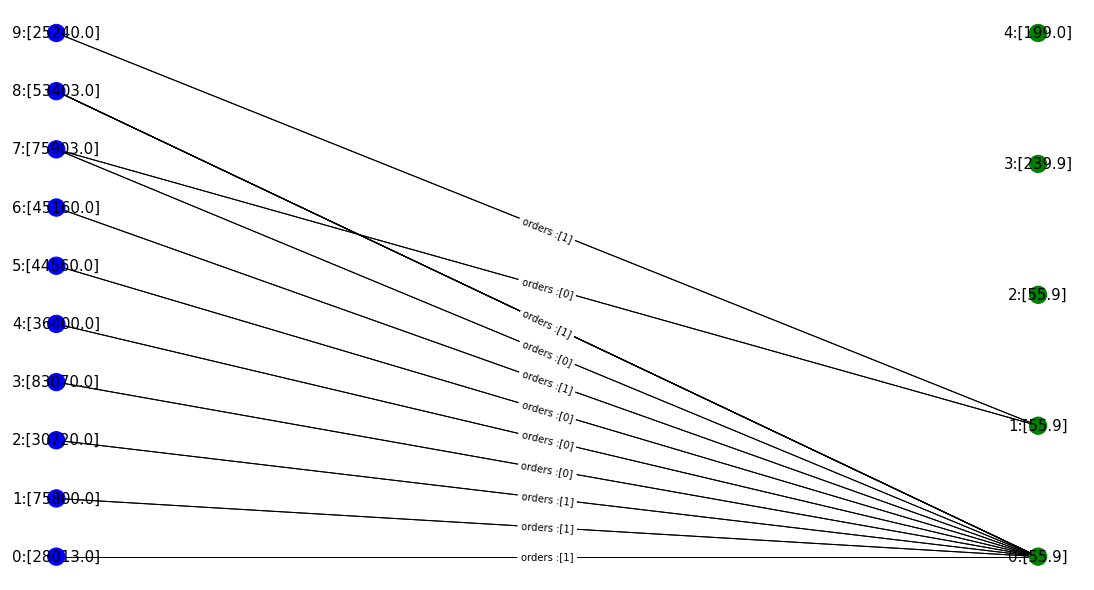

In [345]:
plot_graph(sample_subgraph , edge_type='orders')

In [327]:
df_final[['customer_id_int', 'product_id_int']].head(13)

,customer_id_int,product_id_int
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,7,1
9,8,0


In [218]:
def _process_customer_features(df_final):
    
    HM = {}
    for _, row in df_final.iterrows():   
        HM[row['customer_id_int']] = torch.tensor([row['customer_zip_code_prefix']]).float()
    
    return HM

In [219]:
custid_to_feat = _process_customer_features(df_final)

In [220]:
customer_features = [value[1] for value in list(custid_to_feat.items())]

In [221]:
# node feature assignment

ecommerce_hetero_graph.nodes['customer'].data['features'] = torch.stack(customer_features, axis=0)

In [361]:
def _process_product_features(df_final):
    
    HM = {}
    
    for _, row in df_final.iterrows():
        HM[row['product_id_int']] = torch.tensor([round(row['price'], 4), row['purchase_weekofyear']])
    
    return HM

In [362]:
prodid_to_feat = _process_product_features(df_final)

In [363]:
product_features = [value[1] for value in list(prodid_to_feat.items())]

In [364]:
# node feature assignment
ecommerce_hetero_graph.nodes['product'].data['features'] = torch.stack(product_features, axis=0)    

In [365]:
ecommerce_hetero_graph

Graph(num_nodes={'customer': 96516, 'product': 32171},
      num_edges={('customer', 'orders', 'product'): 115609, ('product', 'rev-orders', 'customer'): 115609},
      metagraph=[('customer', 'product', 'orders'), ('product', 'customer', 'rev-orders')])

In [227]:
# edge feature assignment
edge_features = df_final['is_reviewed'].tolist()
ecommerce_hetero_graph.edges['orders'].data['features']= torch.tensor(edge_features).unsqueeze(-1)
ecommerce_hetero_graph.edges['rev-orders'].data['features']= torch.tensor(edge_features).unsqueeze(-1)

In [228]:
# differnet prices for same product
df_final[df_final.product_id_int == 0].head(3)

,order_id,product_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_score,review_comment_message,customer_id,order_status,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_zip_code_prefix,customer_city,customer_state,sellers_count,products_count,estimated_delivery_time,actual_delivery_time,diff_in_delivery_time,on_time_delivery,avg_product_value,total_order_cost,order_freight_ratio,purchase_dayofweek,purchase_dayofmonth,purchase_weekofmonth,purchase_weekofyear,is_reviewed,customer_id_int,product_id_int
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,5,"Perfeito, produto entregue antes do combinado.",3ce436f183e68e07877b285a838db11a,delivered,2017-09-20,2017-09-29,1,credit_card,2,72.19,28013,campos dos goytacazes,RJ,9,1,16,7,9,1,58.9,72.19,0.225637,2,13,1,37,1,0,0
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,55.9,17.96,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,5,"lannister como sempre, entregou certinho e den...",e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-07-13,2017-07-26,1,boleto,1,73.86,75800,jatai,GO,9,1,27,14,13,1,55.9,73.86,0.321288,2,28,4,26,1,1,0
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,64.9,18.33,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,4,carrinho muito bonito,4ef55bf80f711b372afebcb7c715344a,delivered,2018-06-04,2018-06-07,1,credit_card,2,83.23,30720,belo horizonte,MG,9,1,20,17,3,1,64.9,83.23,0.282435,4,18,2,20,1,2,0


## Dataset Split

In [349]:
train_eids_dict = {}
valid_eids_dict = {}
test_eids_dict = {}

eids = np.arange(ecommerce_hetero_graph.number_of_edges(etype='orders'))
eids = np.random.permutation(eids)

test_size = int(len(eids) * 0.2)
valid_size = int(len(eids) * 0.1)
train_size = len(eids) - test_size - valid_size

for e in ecommerce_hetero_graph.etypes:
    train_eids_dict[e] = eids[:train_size]
    valid_eids_dict[e] = eids[train_size:train_size+valid_size]
    test_eids_dict[e] = eids[-test_size:]

train_g = dgl.edge_subgraph(ecommerce_hetero_graph, train_eids_dict, relabel_nodes=False)
# check if relabel is needed
valid_g = dgl.edge_subgraph(ecommerce_hetero_graph, valid_eids_dict, relabel_nodes=False)
test_g = dgl.edge_subgraph(ecommerce_hetero_graph, test_eids_dict, relabel_nodes=False)

In [350]:
train_g

Graph(num_nodes={'customer': 96516, 'product': 32171},
      num_edges={('customer', 'orders', 'product'): 80928, ('product', 'rev-orders', 'customer'): 80928},
      metagraph=[('customer', 'product', 'orders'), ('product', 'customer', 'rev-orders')])

In [351]:
valid_g

Graph(num_nodes={'customer': 96516, 'product': 32171},
      num_edges={('customer', 'orders', 'product'): 11560, ('product', 'rev-orders', 'customer'): 11560},
      metagraph=[('customer', 'product', 'orders'), ('product', 'customer', 'rev-orders')])

## Experiment with negative graph

In [353]:
def construct_negative_graph(graph, k, etype_list):
    HM = {}
    for etype in etype_list:
        utype, _, vtype = etype
        src, dst = graph.edges(etype=etype)
        neg_src = src.repeat_interleave(k)
        neg_dst = torch.randint(0, graph.num_nodes(vtype), (len(src) * k,))
        HM[etype] = (neg_src[:], neg_dst[:])

    return dgl.heterograph(
        HM,
        num_nodes_dict={ntype: graph.num_nodes(ntype) for ntype in graph.ntypes})

In [557]:
negative_graph = construct_negative_graph(train_g, 3, train_g.canonical_etypes)

In [536]:
negative_graph =  construct_negative_graph(sample_subgraph, 3, sample_subgraph.canonical_etypes)

## Visualization

In [112]:
import dgl.function as fn
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_graph(G, edge_type='rates'):
    
    Gnx = dgl.to_networkx(dgl.to_homogeneous(G))
#     pos = nx.spring_layout(Gnx, k=1/np.sqrt(len(Gnx.nodes())), iterations=10)
    
    node_attrs = defaultdict(dict)
    for ntype in G.ntypes:
        for index, value in enumerate(G.nodes[ntype].data['features'].tolist()):
            node_attrs[ntype][index] = [round(value[0], 2)]
    
    edge_attrs = defaultdict(dict)
    for etype in G.etypes:
        for index, value in enumerate(G.edges[etype].data['features'].tolist()):
            edge_attrs[etype][index] = value
    
    E = {}
    for index, edge in enumerate(list(Gnx.edges())):
        if index < G.num_edges(etype=edge_type):
            E[edge] = '%s :'%edge_type + str(edge_attrs[edge_type][index])
#         else:
#             E[edge] = 'rates' 
    

    color_map = []
    one_side_nodes = []
    for node in Gnx:
        if node < G.num_nodes('customer'):
            color_map.append('blue')
            one_side_nodes.append(node)
        else:
            color_map.append('green')
    
    print(one_side_nodes)
    pos=nx.bipartite_layout(Gnx, one_side_nodes)
    
    user_nodes = (G.nodes(ntype='customer'))
    movie_nodes = (G.nodes(ntype='product'))
    
    labeldict = {}
    for node in Gnx:
        if node < G.num_nodes('customer'):
            labeldict[node] = str(node) + ':' + str(node_attrs['customer'][node])
#             code change to display new IDs and not old IDs
#             labeldict[node] = str(movie_nodes[node]) + ':' + str(node_attrs['movie'][node])
        else:
            updated_index = node - G.num_nodes('customer')
            labeldict[node] = str(updated_index) + ':' + str(node_attrs['product'][updated_index])
#             labeldict[node] = str(user_nodes[updated_index]) + ':' + str(node_attrs['user'][updated_index])
    
    plt.figure(3,figsize=(15,8)) 
    nx.draw(Gnx, pos=pos, labels=labeldict, font_size = 15,  node_color=color_map, with_labels=True,  arrows=False)
    
    nx.draw_networkx_edge_labels(Gnx, pos=pos,  edge_labels=E)
    
    plt.show()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


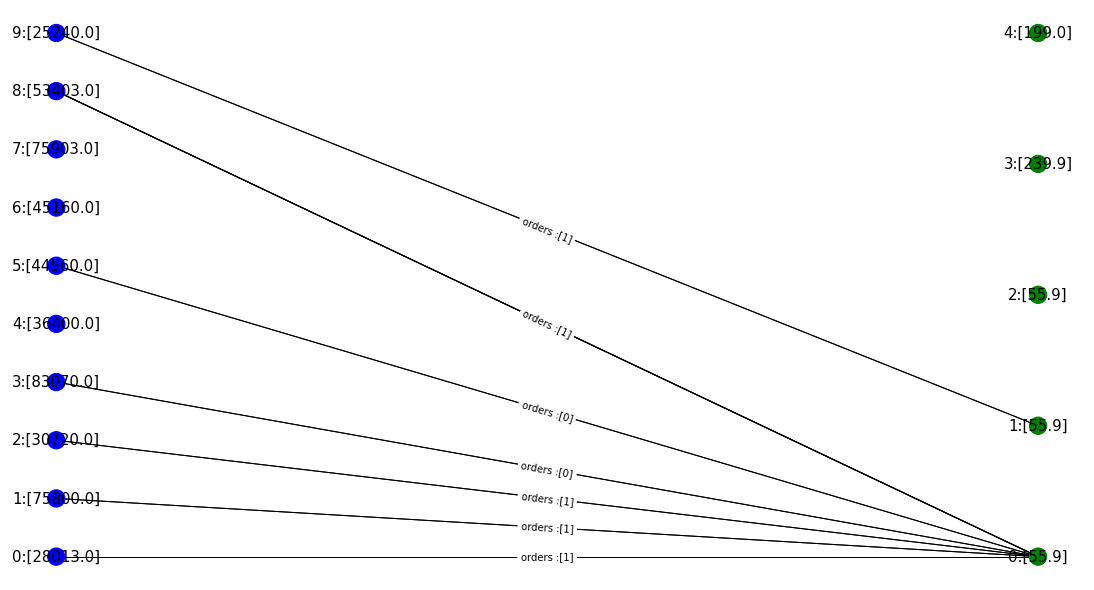

In [359]:
sample_subgraph = train_g.subgraph({ 'customer' :list(range(10)), 'product': list(range(5))})

# plot_graph(sample_subgraph , edge_type='rev-orders')
plot_graph(sample_subgraph , edge_type='orders')

## Running GNN

In [ ]:
import dgl, os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [609]:
dim_dict = {'customer': train_g.nodes['customer'].data['features'].shape[1],
            'product': train_g.nodes['product'].data['features'].shape[1],
            'edge_dim': ecommerce_hetero_graph.edges['orders'].data['features'].shape[1],
            'hidden_dim' : 128,
            'out_dim': 16
           }

In [602]:
import dgl.function as fn

class GNNLayer(nn.Module):

    def __init__(self, input_graph, dim_dict):
        
        super().__init__()
        self.node_in_feats = dim_dict['out_dim']
        self.node_out_feats = dim_dict['out_dim']

        self.edge_fc = nn.ModuleDict({
            name[1] : nn.Sequential(
                nn.Linear(dim_dict['edge_dim'], dim_dict['hidden_dim']),
                nn.ReLU(),
                nn.Linear(dim_dict['hidden_dim'], self.node_out_feats * self.node_out_feats),
                nn.Dropout(p=0.5)
                # check if dropout is necessary
            ) for name in input_graph.canonical_etypes
        })
    
    def udf_u_mul_e(self, nodes):
#         print("Important Shapes :", nodes.src['node_weights'], nodes.data['edge_weights'].shape)
        return {'m': nodes.src['node_weights'] * nodes.data['edge_weights'] }
    
    def reduce_func(self, nodes):
        return {'h': torch.mean(nodes.mailbox['m'], dim=1)}
    
    def forward(self, pos_g, feat_dict, edge_dict):

        funcs = {}
        for c_etype in pos_g.canonical_etypes:
            
            srctype, etype, dsttype = c_etype
            
#             print("Source",srctype, etype, "Destination",dsttype)
            
            node_weights = feat_dict[srctype].unsqueeze(-1)
#             print("Source type", srctype)
#             print("Node weights :", node_weights.shape)

#             pos_g.nodes[srctype].data['node_weights_%s' % etype] = node_weights
            pos_g.nodes[srctype].data['node_weights'] = node_weights

            edge_weights = self.edge_fc[etype](edge_dict[etype]).view(-1, self.node_in_feats, self.node_out_feats)
            
#             print("Edge weights :",edge_weights.shape, edge_dict[etype])
            pos_g[etype].edata['edge_weights'] = edge_weights
#             pos_g[etype].edata['edge_weights_%s' % etype] = edge_weights
            
#             funcs[etype] = (fn.u_mul_e('node_weights_%s' % etype, 'edge_weights_%s' % etype,'m'), self.reduce_func)
            funcs[etype] = (self.udf_u_mul_e, self.reduce_func)

        pos_g.multi_update_all(funcs, 'mean')
        results = {ntype : pos_g.nodes[ntype].data['h'].sum(dim=1) for ntype in pos_g.ntypes}
        
#         print("Results : ",results)
        
        return results

class GNNMODEL(nn.Module):

    def __init__(self, G, dim_dict, num_step_message_passing):

        super(GNNMODEL, self).__init__()
        
#         # Added an activation function here : check if actually required. 
#         self.project_node_features = nn.ModuleDict({
#             name[0] : nn.Sequential(nn.Linear(dim_dict[name[0]], dim_dict['out_dim']), nn.Softmax(dim=0)) for name in G.canonical_etypes
#         })
        
        self.project_node_features = nn.ModuleDict({
            name[0] : nn.Sequential(nn.Linear(dim_dict[name[0]], dim_dict['out_dim']), nn.ReLU()) for name in G.canonical_etypes
        })
        
        self.num_step_message_passing = num_step_message_passing
        self.gnn_layer = GNNLayer(G, dim_dict=dim_dict)
    
    def forward(self, pos_g, node_feats, edge_feats):
        
#         print("Pre-projected Node Features :", node_feats)
        
        for feat in node_feats:
            node_feats[feat] = self.project_node_features[feat](node_feats[feat])
            
#         print("Projected Node Features : ", node_feats)
        
        for i in range(self.num_step_message_passing):
            node_feats = self.gnn_layer(pos_g, node_feats, edge_feats)
#             print("Layer :"+str(i))
#             print(node_feats)
        
#         return self.predictor(g, node_feats), self.predictor(node_subgraph_negative, node_feats)
        
        for feat in node_feats:
            node_feats[feat] = F.relu(node_feats[feat])
    
        return node_feats


In [603]:
class CosinePrediction(nn.Module):
    """
    Scoring function that uses cosine similarity to compute similarity between user and item.

    Only used if fixed_params.pred == 'cos'.
    """
    def __init__(self):
        super().__init__()

    def forward(self, graph, h):
        
        print("h values", h['customer'].shape, h['product'].shape)
        with graph.local_scope():
            for etype in graph.canonical_etypes:
                try:
                    graph.nodes[etype[0]].data['norm_h'] = F.normalize(h[etype[0]], p=2, dim=-1)
                    graph.nodes[etype[2]].data['norm_h'] = F.normalize(h[etype[2]], p=2, dim=-1)
#                     print(etype[0], h[etype[0]])
                    graph.apply_edges(fn.u_dot_v('norm_h', 'norm_h', 'cos'), etype=etype)
                except KeyError:
                    pass  # For etypes that are not in training eids, thus have no 'h'
            ratings = graph.edata['cos']
        
        print(ratings[('customer', 'orders', 'product')].shape)
        return ratings

class GNNPredictor(nn.Module):
    
    def __init__(self, input_graph, dim_dict):
        
        super(GNNPredictor, self).__init__()
        
        self.gnn = GNNMODEL(G = input_graph,
                            dim_dict = dim_dict,
                            num_step_message_passing = 2)

        self.predictor = CosinePrediction()
        self.node_feats = None
    
    def forward(self, g, neg_g, node_feats, edge_feats):

        node_feats = self.gnn(g, node_feats, edge_feats)
        
        self.node_feats = node_feats
        
        return self.predictor(g, node_feats), self.predictor(neg_g, node_feats)
    
    def get_repr(self, g, node_feats, edge_feats):        
        node_feats = self.gnn(g, node_feats, edge_feats)
        return node_feats

In [604]:
mpnn_model = GNNPredictor(train_g, dim_dict)
optimizer = torch.optim.Adam(mpnn_model.parameters(), lr=0.0001,weight_decay=0)

In [605]:
def max_margin_loss(pos_score, neg_score, delta=0.5):

    all_scores = torch.empty(0)
    
    for etype in pos_score.keys():
        neg_score_tensor = neg_score[etype]
        pos_score_tensor = pos_score[etype]

        neg_score_tensor = neg_score_tensor.reshape(pos_score_tensor.shape[0], -1)
        scores = (neg_score_tensor - pos_score_tensor + delta).clamp(min=0)

        relu = nn.ReLU()
        scores = relu(scores)
        all_scores = torch.cat((all_scores, scores), 0)

    return torch.mean(all_scores)

In [606]:
negative_graph.edges(etype='orders')

(tensor([71425, 71425, 71425,  ...,  7579,  7579,  7579]),
 tensor([24315,  5596, 24623,  ...,  5717,  9600, 18285]))

In [607]:
sample_subgraph.edges(etype='orders')

(tensor([0, 1, 2, 3, 5, 8, 8, 9]), tensor([0, 0, 0, 0, 0, 0, 0, 1]))

In [594]:
sample_subgraph

Graph(num_nodes={'customer': 10, 'product': 5},
      num_edges={('customer', 'orders', 'product'): 8, ('product', 'rev-orders', 'customer'): 8},
      metagraph=[('customer', 'product', 'orders'), ('product', 'customer', 'rev-orders')])

In [595]:
sample_subgraph

Graph(num_nodes={'customer': 10, 'product': 5},
      num_edges={('customer', 'orders', 'product'): 8, ('product', 'rev-orders', 'customer'): 8},
      metagraph=[('customer', 'product', 'orders'), ('product', 'customer', 'rev-orders')])

In [608]:
for e in range(10):
    
    optimizer.zero_grad()
    
    node_features = train_g.ndata['features']
    edge_features = train_g.edata['features']
    
    edge_features_HM = {}
    for key, value in edge_features.items():
        edge_features_HM[key[1]] = value.to(torch.float)
    
    pos_score, neg_score = mpnn_model(train_g, negative_graph, node_features, edge_features_HM)
    
    loss = max_margin_loss(pos_score, neg_score)
    
    print("Epoch : {}, Training loss : {}".format(e, loss.item()))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
#     print(pos_score, neg_score)
    print('--------------------------------------------')

KeyboardInterrupt: 

In [600]:
for name, param in mpnn_model.named_parameters():
    if param.requires_grad:
        print(name, param.grad.shape)
#     print(param, param.grad)

gnn.project_node_features.customer.0.weight torch.Size([16, 1])
gnn.project_node_features.customer.0.bias torch.Size([16])
gnn.project_node_features.product.0.weight torch.Size([16, 1])
gnn.project_node_features.product.0.bias torch.Size([16])
gnn.gnn_layer.edge_fc.orders.0.weight torch.Size([128, 1])
gnn.gnn_layer.edge_fc.orders.0.bias torch.Size([128])
gnn.gnn_layer.edge_fc.orders.2.weight torch.Size([256, 128])
gnn.gnn_layer.edge_fc.orders.2.bias torch.Size([256])
gnn.gnn_layer.edge_fc.rev-orders.0.weight torch.Size([128, 1])
gnn.gnn_layer.edge_fc.rev-orders.0.bias torch.Size([128])
gnn.gnn_layer.edge_fc.rev-orders.2.weight torch.Size([256, 128])
gnn.gnn_layer.edge_fc.rev-orders.2.bias torch.Size([256])


In [576]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(mpnn_model.gnn.project_node_features['customer']): # note: exclude the output layer
    print(layer)
    if isinstance(layer, nn.ReLU):
        t = layer.out
        print(t)
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

Linear(in_features=1, out_features=16, bias=True)
ReLU()


AttributeError: 'ReLU' object has no attribute 'out'

<Figure size 1440x288 with 0 Axes>

torch.Size([16, 1])
torch.Size([16])
torch.Size([16, 1])
torch.Size([16])


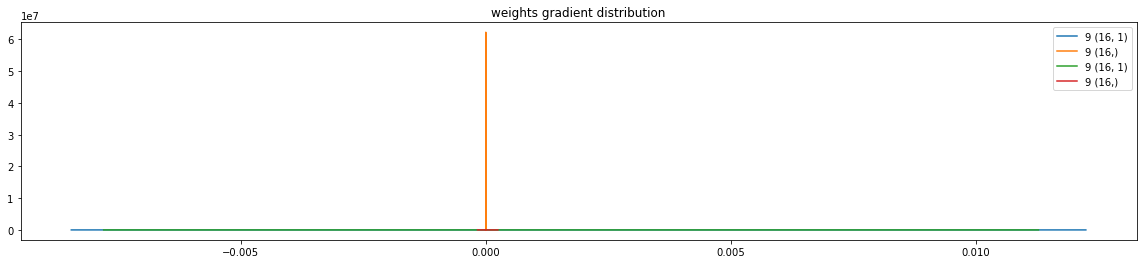

In [571]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for name, param in mpnn_model.named_parameters():
    if param.requires_grad and "project_node_features" in name :
        t = param.grad
        print(t.shape)
#         print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(param.shape)}')
        
    plt.legend(legends)
    plt.title('weights gradient distribution');

In [538]:
mpnn_model.node_feats

{'customer': tensor([[2.9047e-01, 0.0000e+00, 2.4570e-01, 2.8768e-01, 0.0000e+00, 2.6530e-01,
          1.2303e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 2.7535e-01, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9328e-01, 3.7134e-02, 0.0000e+00,
          2.6453e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.5241e-02, 0.0000e+00,
          0.0000e+00, 9.5598e-02, 0.0000e+00, 7.5655e-02],
         [8.4317e-02, 3.6693e-02, 0.0000e+00, 9.6659e-01, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 3.3756e-02, 0.0000e+00, 4.4253e-03, 0.0000e+00, 0.0000e+00,
          1.2942e-02, 5.7457e-02, 0.0000e+00, 4.0253e-01],
         [1.0544e-01, 0.0000e+00, 0.0000e+00, 5.2506e-01, 1.1783e-01, 1.3358e-01,
          1.4528e-01, 0.0000e+00, 8.9365e-02, 1.1691e-03, 0.0000e+00, 2.7486e-01,
          2.6094e-01, 1.7909e-02, 5.2922e-02, 3.1594e-01],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.00

In [547]:
is_zero_cust = torch.all(mpnn_model.node_feats['customer'] == 0, dim=1)

In [548]:
is_zero_cust

tensor([False, False, False, False,  True, False,  True,  True, False, False])

In [549]:
is_zero_prod = torch.all(mpnn_model.node_feats['product'] == 0, dim=1)

In [550]:
is_zero_prod

tensor([False, False,  True,  True,  True])

In [455]:
edge_features = test_g.edata['features']

edge_features_HM = {}
for key, value in edge_features.items():
    edge_features_HM[key[1]] = value.to(torch.float)

h = mpnn_model.get_repr(test_g, test_g.ndata['features'], edge_features_HM)

In [462]:
h['customer'][1000]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SelectBackward0>)

In [465]:
test_g.out_edges(1000, etype='rev-orders')

(tensor([1000]), tensor([15739]))

In [415]:
t = torch.tensor([[1.,2.,3.],
                  [4.,5.,6.]])

In [422]:
t1 = F.normalize(t, p=2.0, dim = -1)

In [ ]:
t2 = F.normalize(t, p=2.0, dim = 1)

In [424]:
t1 == t1

tensor([[True, True, True],
        [True, True, True]])